**Задача:** спрогнозировать число пассажиров авиакомпании помесячно.

In [1]:
import re

import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

1. Загрузите данные из источника по ссылке, ознакомьтесь с ними и подготовьте к аналитике

a. Найдите и удалите пропуски, если они есть.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/carolinesofina/DS_sets/main/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Переименуем сразу столбцы

In [3]:
# избавляемся от всех спецсимволов и понижаем регистр
df.columns = [re.sub('[^а-яА-ЯёЁa-zA-Z0-9\\s]', '', i).lower() for i in df]
df.sample()

,month,passengers
37,1952-02,180


b. Поменяйте тип столбца с временными отсечками в datetime.

In [4]:
df.month = pd.to_datetime(df.month, format="%Y-%m")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   month       144 non-null    datetime64[ns]
 1   passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


c. Установите индексом данных столбец с временными отсечками и убедитесь, что он монотонно возрастает.

In [5]:
df.set_index('month', inplace=True)

In [6]:
df.index.is_monotonic_increasing

True

2. Проанализируйте временной ряд

a. Оставьте для аналитики лишь с 1952 по 1957 год (включительно).

In [7]:
df_main = df['1952':'1957']

b. Реализуйте разложение на компоненты тренда и сезонности. Визуализируйте результат разложения и сделайте выводы.

In [8]:
decomposed = seasonal_decompose(df_main['passengers']) 

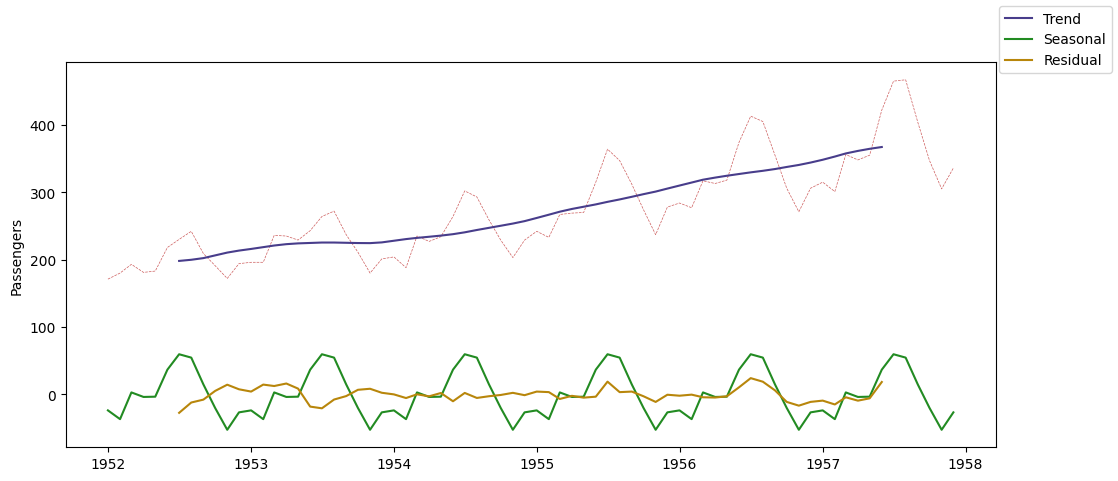

In [9]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(df_main['passengers'], c='indianred', linewidth=0.5, linestyle='--')
ax.plot(decomposed.trend, c='darkslateblue', label='Trend')
ax.plot(decomposed.seasonal, c='forestgreen', label='Seasonal')
ax.plot(decomposed.resid, c='darkgoldenrod', label='Residual')
ax.set_ylabel('Passengers')

fig.legend();

- Есть ли тренд?

Наблюдается восходящий тренд - количество пассажиров растет год от года.

- Есть ли сезонность и какая она (ежемесячная/ежеквартальная/ежегодная и т.д.)?

Наблюдается ежегодная сезонность - отрезки графика сезонности в разные годы идентичные.

- Является ли ряд стационарным и почему?

Ряд не является стационарным, т.к. наблюдается явно выраженный восходящий тренд. Проверим эту гипотезу с помощью расширенного теста Дики-Фуллера.

In [10]:
alpha = .05

pvalue = adfuller(df_main['passengers'])[1]

if pvalue < alpha:
    print(f'P-value: {pvalue:.5f}. Ряд стационарный.')
else:
    print(f'P-value: {pvalue:.5f}. Ряд не стационарный.')

P-value: 0.99252. Ряд не стационарный.


c. Постройте график, чтобы оценить автокорреляцию и сделайте выводы

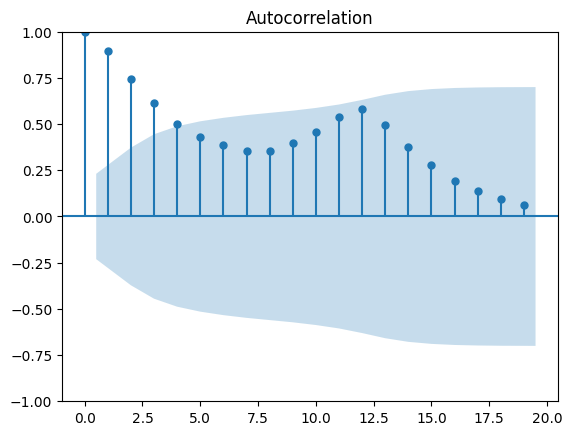

In [11]:
fig = tsaplots.plot_acf(df_main['passengers'])
plt.show() 

- У какого сдвига самая высокая автокорреляция?

Самая высокая автокорреляция у сдвига 1 месяц. Также высокие значения у сдвигов 2, 3 и 4 месяца.

- Подтверждаются ли выводы о наличии тренда графиком автокорреляции?

Да, подтверждается, т.к. все значения автокорреляции выше нуля.

3. Подготовьте данные к обучению линейной модели

a. Напишите функцию, которая будет генерировать новые признаки (календарные признаки, несколько колонок с разными сдвигами, несколько колонок с разными скользящими средними)

- Воспользуйтесь наработками из скринкастов.

- Добавьте аргумент, который будет отвечать за возможные сдвиги. Это должен быть список, по которому в цикле будет добавляться новая колонка lag_n, где n — число из этого списка, отвечающее за сдвиг.

- Добавьте аргумент, который будет отвечать за возможные размеры скользящего среднего. Это должен быть список, по которому в цикле будет добавляться новая колонка rolling_mean_m, где m — число из этого списка, отвечающее за размер окна, по которому вычисляется среднее. Не забудьте, что скользящее среднее нужно сдвигать, чтобы не было «заглядывания в будущее».

In [12]:
def make_features(df, lags, rolling_mean_sizes):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    
    for i in lags:
        df[f'lag_{i}'] = df['passengers'].shift(i)

    for j in rolling_mean_sizes:
        df[f'rolling_mean_{j}'] = df['passengers'].rolling(j).mean()

        df[f'rolling_mean_{j}'] = df[f'rolling_mean_{j}'].shift(1)
    
    return df

b. Рассчитайте новые признаки с помощью реализованной функции, подав ей на вход произвольные параметры генерации новых признаков.

In [13]:
df_with_features = make_features(df_main[['passengers']].copy(),
                                 [1, 2, 3, 4], [3, 6, 9, 12]
                                 )
df_with_features.head()

,passengers,year,month,quarter,lag_1,lag_2,lag_3,lag_4,rolling_mean_3,rolling_mean_6,rolling_mean_9,rolling_mean_12
month,,,,,,,,,,,,
1952-01-01,171,1952,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952-02-01,180,1952,2,1,171.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952-03-01,193,1952,3,1,180.0,171.0,NaN,NaN,NaN,NaN,NaN,NaN
1952-04-01,181,1952,4,2,193.0,180.0,171.0,NaN,181.333333,NaN,NaN,NaN
1952-05-01,183,1952,5,2,181.0,193.0,180.0,171.0,184.666667,NaN,NaN,NaN


c. Удалите наблюдения с пропусками в новых переменных.

In [14]:
df_with_features.dropna(inplace=True)

d. Разделите данные на признаки и целевую переменную.

In [15]:
target = df_with_features['passengers']
features = df_with_features.drop(['passengers'], axis=1)

e. Разделите данные на обучающую и валидационную части. Не забудьте, что валидационная часть должна идти строго после обучающей.

In [16]:
features_train, features_val, target_train, target_val = train_test_split(
                                                            features, target,
                                                            test_size=0.2,
                                                            shuffle=False
                                                            )

4. Обучите линейную модель машинного обучения и оцените ее качество

a. Обучите линейную модель на обучающей части данных.

In [17]:
model = LinearRegression()
model.fit(features_train, target_train)

prediction_train = pd.Series(model.predict(features_train))
prediction_train.index = features_train.index
prediction_val = pd.Series(model.predict(features_val))
prediction_val.index = features_val.index

b. Рассчитайте значение метрики качества MAE на обучающей и валидационных частях. Если модель работает плохо (метрика выше 20), попробуйте выделить другой набор признаков, вызывая свою функцию с новыми параметрами.

In [18]:
print("MAE обучающей выборки:", mean_absolute_error(target_train,
                                                    prediction_train))
print("MAE тестовой выборки:", mean_absolute_error(target_val, prediction_val))

MAE обучающей выборки: 11.028078936446585
MAE тестовой выборки: 16.913026695444387


c. Визуализируйте реальный временной ряд и прогнозные значения. 

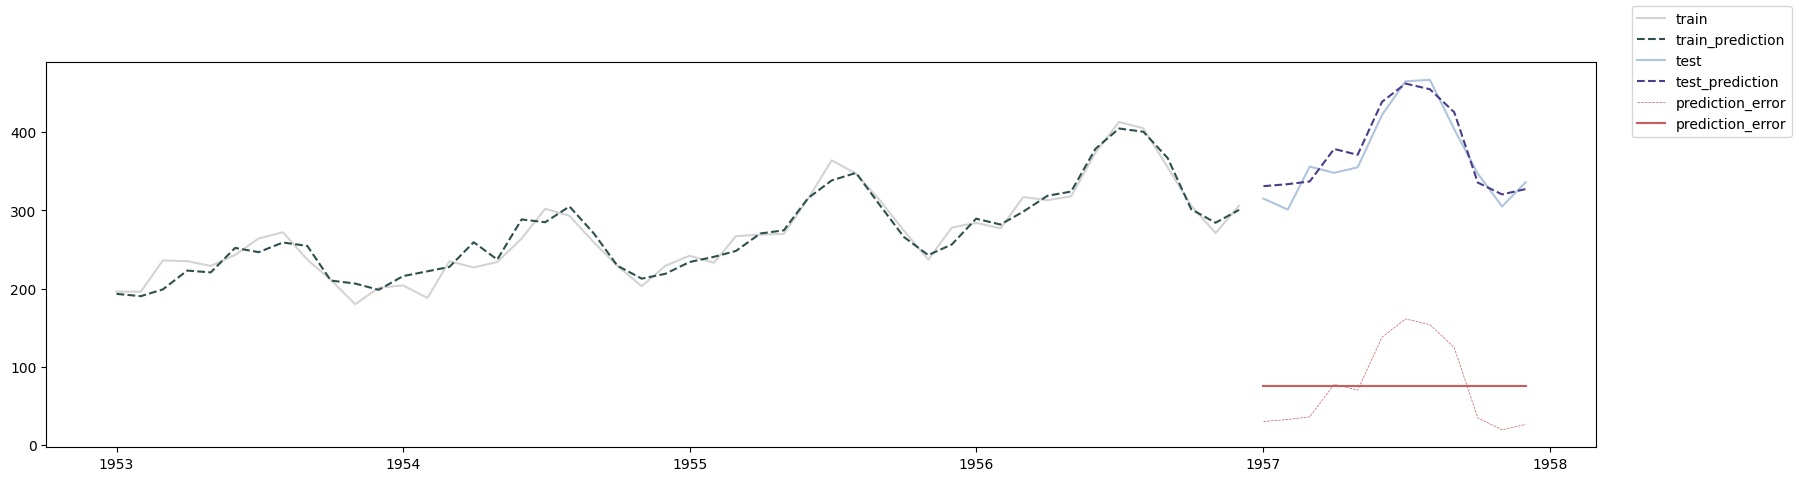

In [19]:
fig, ax = plt.subplots(1, 1, figsize=[20, 5])

error = abs(target_val[1] - prediction_val)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = target_val.index

ax.plot(target_train, c='lightgrey', label='train')
ax.plot(prediction_train, c='darkslategrey', label='train_prediction',
        linestyle='--')
ax.plot(target_val, c='lightsteelblue', label='test')
ax.plot(prediction_val, c='darkslateblue', label='test_prediction',
        linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error',
        linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend();

Качество полученной модели довольно высокое, тренд на обучаемой и валидационной выборке предсказан верно.

5. Оцените качество модели на отложенной выборке. В качестве отложенной выборки у нас будут наблюдения с 1958 по 1960 год

a. Возьмите из источника необходимый срез данных.

In [20]:
df_del = df['1958':'1960']

b. Подготовьте данные к прогнозированию.

- Добавьте признаки с помощью реализованной ранее функции.

In [21]:
df_del_with_features = make_features(df_del[['passengers']].copy(),
                                 [1, 2, 3, 4], [3, 6, 9, 12]
                                 )
df_del_with_features.head()

,passengers,year,month,quarter,lag_1,lag_2,lag_3,lag_4,rolling_mean_3,rolling_mean_6,rolling_mean_9,rolling_mean_12
month,,,,,,,,,,,,
1958-01-01,340,1958,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958-02-01,318,1958,2,1,340.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958-03-01,362,1958,3,1,318.0,340.0,NaN,NaN,NaN,NaN,NaN,NaN
1958-04-01,348,1958,4,2,362.0,318.0,340.0,NaN,340.000000,NaN,NaN,NaN
1958-05-01,363,1958,5,2,348.0,362.0,318.0,340.0,342.666667,NaN,NaN,NaN


- Удалите наблюдения с пропусками.

In [22]:
df_del_with_features.dropna(inplace=True)
df_del_with_features.shape[0]

24

- Если после удаления у вас осталось менее 36 наблюдений, откорректируйте срез из пункта 5.а.

In [23]:
# 1960 год последний, так что остается только захватить часть исходной выборки
# это часть попала в валидацинную выборку, т.е. на ней модель не училась

df_del = df['1957':'1960']
df_del_with_features = make_features(df_del[['passengers']].copy(),
                                 [1, 2, 3, 4], [3, 6, 9, 12]
                                 )

df_del_with_features.dropna(inplace=True)
df_del_with_features.shape[0]

36

- Отделите целевую переменную от признаков.

In [24]:
target_del = df_del_with_features['passengers']
features_del = df_del_with_features.drop(['passengers'], axis=1)

c. Постройте прогноз с помощью обученной ранее линейной модели.

In [25]:
prediction_del_val = pd.Series(model.predict(features_del))
prediction_del_val.index = features_del.index

d. Рассчитайте значение метрики качества на отложенной выборке.

In [26]:
print("MAE отложенной выборки: ", mean_absolute_error(target_del,
                                                      prediction_del_val))

MAE отложенной выборки:  28.869715300640866


e. Визуализируйте реальный временной ряд и прогнозные значения.

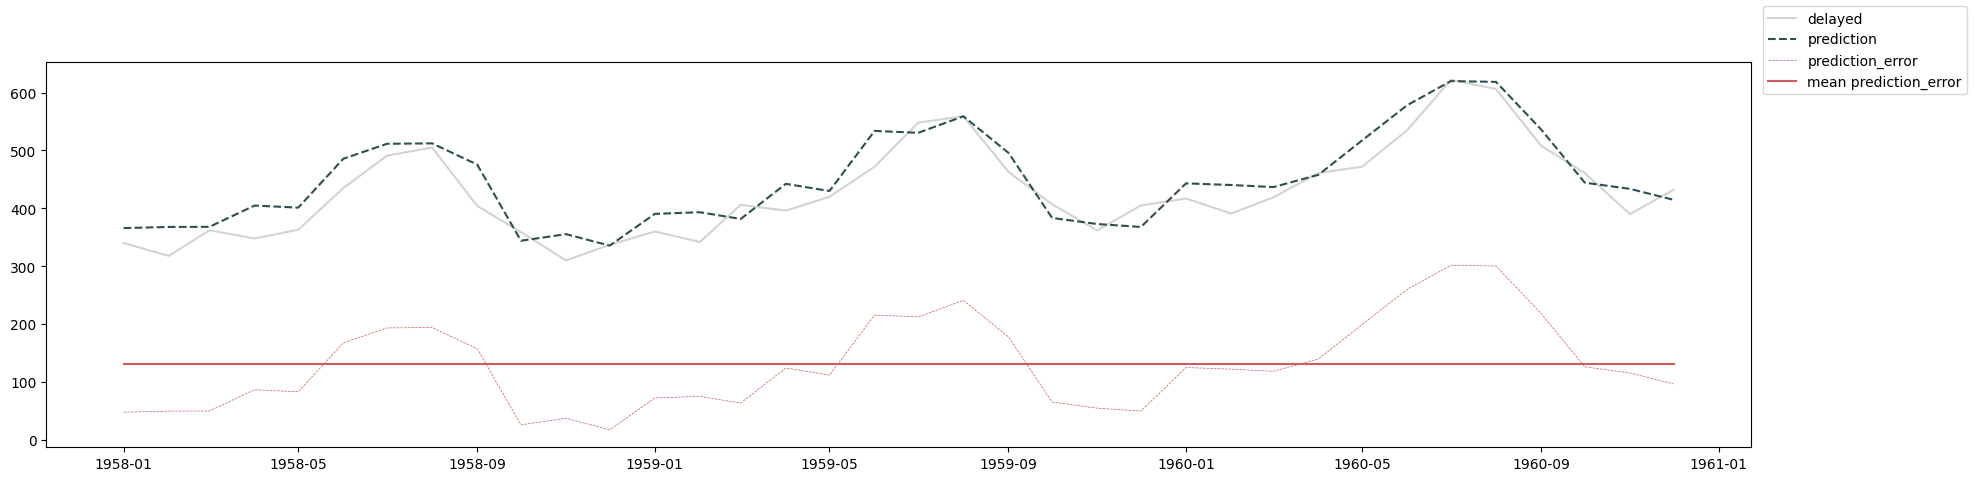

In [27]:
fig, ax = plt.subplots(1, figsize=[22, 5])

error = abs(target_del[1] - prediction_del_val)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = target_del.index

ax.plot(target_del, c='lightgrey', label='delayed')
ax.plot(prediction_del_val, c='darkslategrey', label='prediction',
        linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error',
        linewidth=0.5)
ax.plot(error_mean, c='indianred', label='mean prediction_error')

fig.legend();

6. Значение метрики MAE на отложенной выборке должно быть не более 35.

Условие выполняется - значение MAE на отложенной выборке составило ~29. На графике видно, что модель достаточно точно предсказывает значения целевого показателя.